# Exercise 07: EM algorithm for Gaussian Mixture Model

In this exercise we will implement M-step and E-step of EM algorithm for Gaussian Mixture Model. We will test it and visualize on two example sample.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

Data preparation (sample 1)

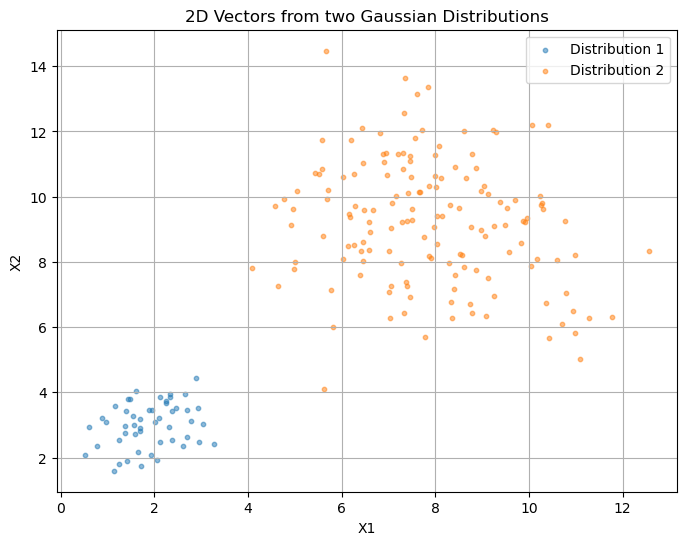

In [4]:
# Parameters for the Gaussian mixtures
mean_1 = [[2, 3], [8, 9]]
cov_1 = [ [[0.5, 0], [0, 0.5]], [[3, 0], [0, 3]] ]  


# Generate samples from each distribution
x_1_1 = np.random.multivariate_normal(mean_1[0], cov_1[0], 50)
x_1_2 = np.random.multivariate_normal(mean_1[1], cov_1[1], 150)

# Combine the samples
x_1 = np.vstack((x_1_1, x_1_2))

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(x_1_1[:, 0], x_1_1[:, 1], alpha=0.5, label='Distribution 1', s=10)
plt.scatter(x_1_2[:, 0], x_1_2[:, 1], alpha=0.5, label='Distribution 2', s=10)
plt.title("2D Vectors from two Gaussian Distributions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

Data preparation (sample 2)

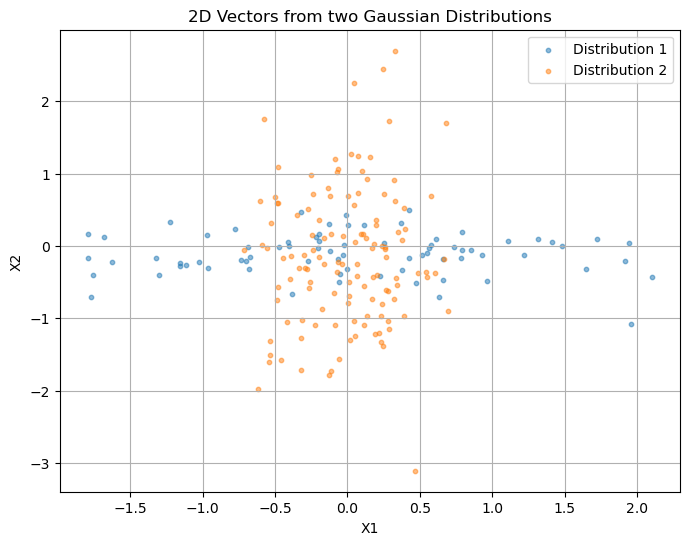

In [6]:
# Parameters for the Gaussian mixtures
mean_2 = [[0, 0], [0, 0]]
cov_2 = [
    [[1, 0], [0, 0.1]],  # Elongated along X-axis
    [[0.1, 0], [0, 1]],  # Elongated along Y-axis
] 


# Generate samples from each distribution
x_2_1 = np.random.multivariate_normal(mean_2[0], cov_2[0], 75)
x_2_2 = np.random.multivariate_normal(mean_2[1], cov_2[1], 125)

# Combine the samples
x_2 = np.vstack((x_2_1, x_2_2))

# Plot the samples
plt.figure(figsize=(8, 6))
plt.scatter(x_2_1[:, 0], x_2_1[:, 1], alpha=0.5, label='Distribution 1', s=10)
plt.scatter(x_2_2[:, 0], x_2_2[:, 1], alpha=0.5, label='Distribution 2', s=10)
plt.title("2D Vectors from two Gaussian Distributions")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

Utility functions

In [9]:
def multivariate_normal_pdf_array(x, mean, cov):
    """
    Calculate the multivariate normal PDF for an array of points.
    
    Parameters:
    - x: ndarray of shape (N, dim)
        Array of points at which to evaluate the PDF.
    - mean: ndarray of shape (dim,)
        The mean of the multivariate normal distribution.
    - cov: ndarray of shape (dim, dim)
        The covariance matrix of the multivariate normal distribution.
        
    Returns:
    - ndarray of shape (N,)
        Array containing the PDF values for each input point.
    """
    x = np.atleast_2d(x)
    mean = np.asarray(mean)
    cov = np.asarray(cov)
    d = mean.shape[0]

    eps = 1e-9
    L = np.linalg.cholesky(cov + eps * np.eye(d))   # regularization
    diff = x - mean                                 # (N, d)

    # Solve L y = diff^T
    y = np.linalg.solve(L, diff.T)                  # (d, N)
    quad = np.sum(y**2, axis=0)                     # (N,)

    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    log_norm_const = -0.5 * (d * np.log(2.0 * np.pi) + logdet)
    log_pdf = log_norm_const - 0.5 * quad
    return np.exp(log_pdf)                          # (N,)

def plot_ellipses(ax, mean, cov, color, label, levels=[1, 2, 3]):
    """
    Add multiple ellipses corresponding to different levels of standard deviations.
    """
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    for level in levels:
        width, height = 2 * level * np.sqrt(eigenvalues)  # Scale by std level
        ellipse = Ellipse(mean, width, height, angle=angle,
                          edgecolor=color, facecolor='none', lw=2, alpha=0.5)
        ax.add_patch(ellipse)

def scatter_cluster(x, w, all_means, all_covariances, threshold=0.5):
    # Assign categories based on probabilities
    probs = w[0]  # responsibilities of component 0
    categories = probs > threshold  # True for "Cluster 1", False for "Cluster 0"

    # Scatter plot
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.scatter(x[categories, 0], x[categories, 1], label="Cluster 1",
                alpha=0.7, color='red', s=10)
    plt.scatter(x[~categories, 0], x[~categories, 1], label="Cluster 0",
                alpha=0.7, color='blue', s=10)
    plt.title("Scatterplot with Two Clusters")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

    all_colors = ['red', 'blue']
    for mean, cov, color in zip(all_means, all_covariances, all_colors):
        plot_ellipses(ax, mean, cov, color, f'Bivariate Normal (mean={mean})', levels=[1, 2, 3])

    plt.show()



Define E-step

In [10]:

def e_step(x, mean, cov, pi):
    """
    Calculate the value of Q-function and matrix W of cluster membership probabilities.
    """
    x = np.asarray(x)
    K = len(mean)
    N = x.shape[0]
    pi = np.asarray(pi, dtype=float)

    # Component PDFs for all points
    pdfs = np.zeros((K, N), dtype=float)
    for k in range(K):
        pdfs[k, :] = multivariate_normal_pdf_array(x, np.asarray(mean[k]), np.asarray(cov[k]))

    # Responsibilities
    tiny = 1e-15
    weighted = (pi[:, None]) * pdfs
    denom = np.sum(weighted, axis=0) + tiny
    w = weighted / denom

    # Q-function
    log_pdfs = np.log(pdfs + tiny)
    log_pi = np.log(pi + tiny)[:, None]
    Q = np.sum(w * (log_pi + log_pdfs))
    return Q, w


Define M-step

In [11]:

def m_step(x, w, mean, cov):
    """
    Calculates the updated values of mean, covariance and pi in GMM.
    """
    x = np.asarray(x)
    w = np.asarray(w)
    K = w.shape[0]
    N, d = x.shape

    Nk = np.sum(w, axis=1)         # (K,)
    pi_new = Nk / float(N)

    mean_new = []
    cov_new = []
    eps = 1e-6

    for k in range(K):
        if Nk[k] < eps:
            mean_new.append(np.asarray(mean[k]))
            cov_new.append(np.asarray(cov[k]))
            continue

        wk = w[k, :][:, None]      # (N, 1)
        mu_k = (wk * x).sum(axis=0) / Nk[k]
        mean_new.append(mu_k)

        diff = x - mu_k            # (N, d)
        Sigma_k = (wk * diff).T @ diff / Nk[k]    # (d, d)
        Sigma_k += eps * np.eye(d)                # regularization
        cov_new.append(Sigma_k)

    mean_new = np.array(mean_new)
    cov_new = np.array(cov_new)

    return pi_new, mean_new, cov_new


Run EM algorithm for sample 1

Iteration   1: Q=-590.4355860551744, pi=[0.28032269 0.03042522], mean=[[2.81805224 3.93581131]
 [1.41018062 2.17504452]]


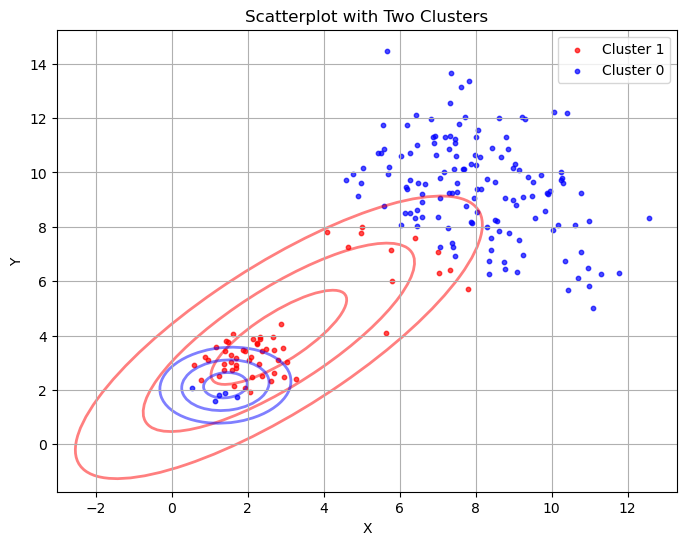

Iteration   2: Q=-1976.5283409697975, pi=[0.95536838 0.04012084], mean=[[6.59082624 7.86483762]
 [1.54871867 2.32314128]]


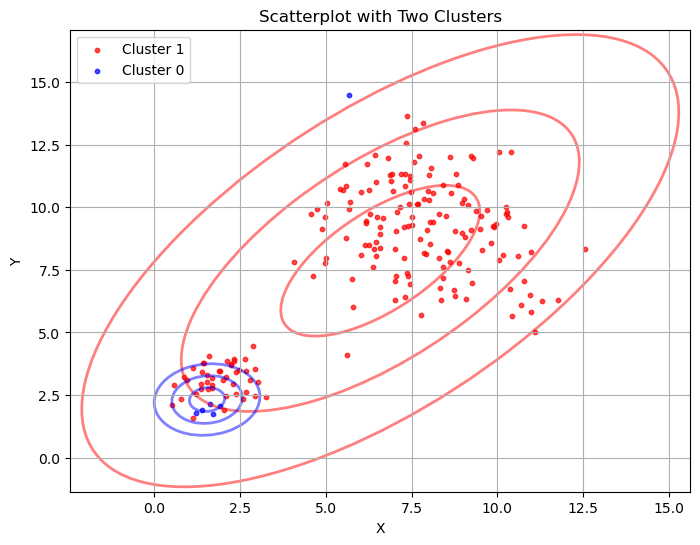

Iteration   3: Q=-950.183785306402, pi=[0.90198495 0.09801505], mean=[[6.90469015 8.22832786]
 [1.59638637 2.55512865]]


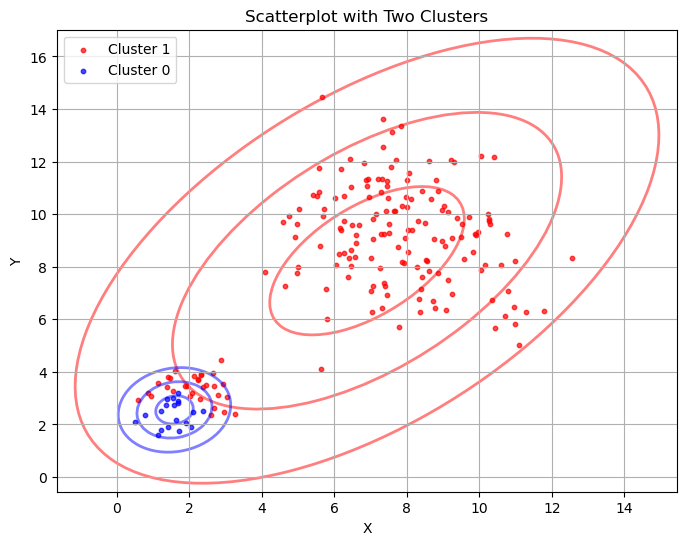

Iteration   4: Q=-919.5037888520518, pi=[0.82742829 0.17257171], mean=[[7.36066422 8.68367743]
 [1.70349312 2.82287655]]


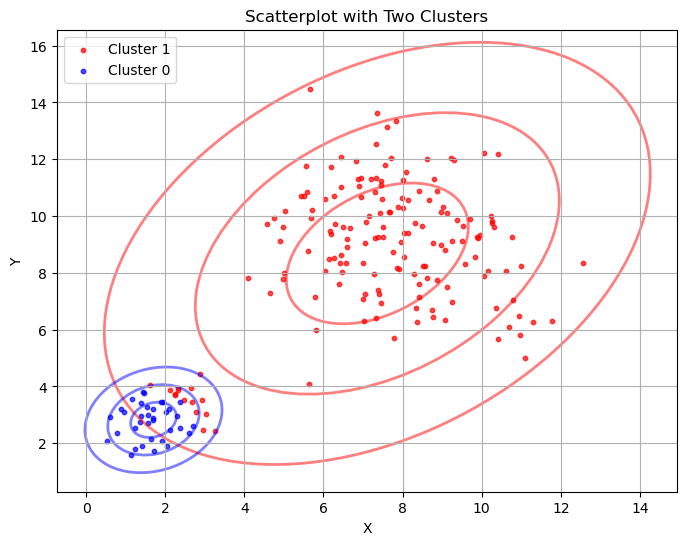

Iteration   5: Q=-863.1107995764658, pi=[0.76382266 0.23617734], mean=[[7.7847668  9.12497073]
 [1.85545002 2.97407696]]


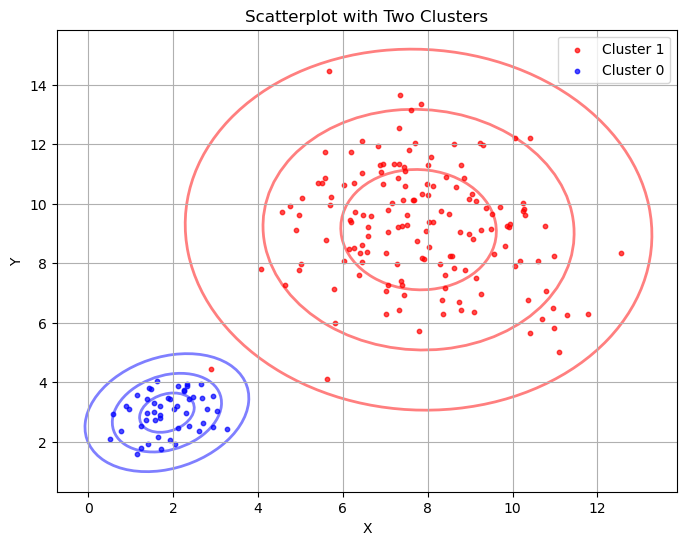

Iteration   6: Q=-815.6433289943475, pi=[0.75009773 0.24990227], mean=[[7.87848092 9.22783946]
 [1.8998061  3.00312415]]


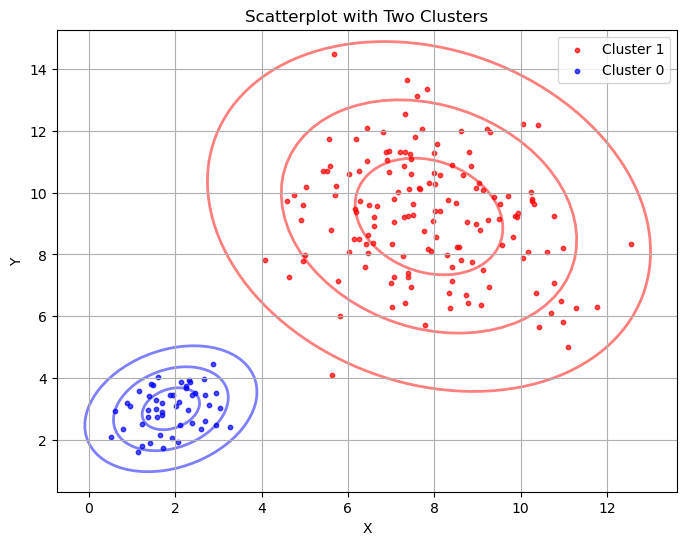

Iteration   7: Q=-811.0286802212042, pi=[0.75000323 0.24999677], mean=[[7.87911773 9.22850107]
 [1.90015574 3.0034924 ]]


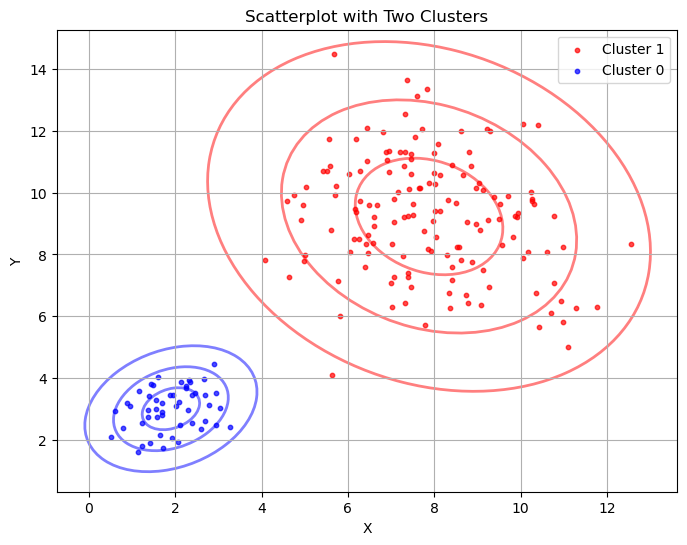

Iteration   8: Q=-811.0282304142526, pi=[0.75000311 0.24999689], mean=[[7.87911847 9.22850186]
 [1.9001563  3.00349293]]


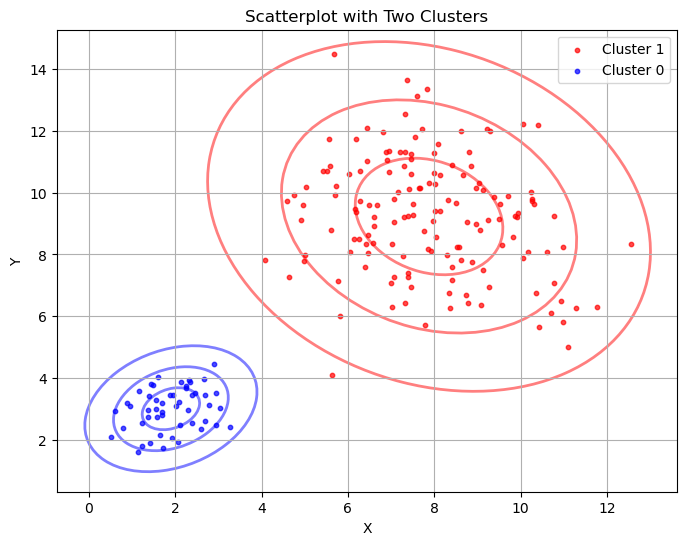

Iteration   9: Q=-811.0282302365206, pi=[0.75000311 0.24999689], mean=[[7.87911847 9.22850186]
 [1.9001563  3.00349293]]


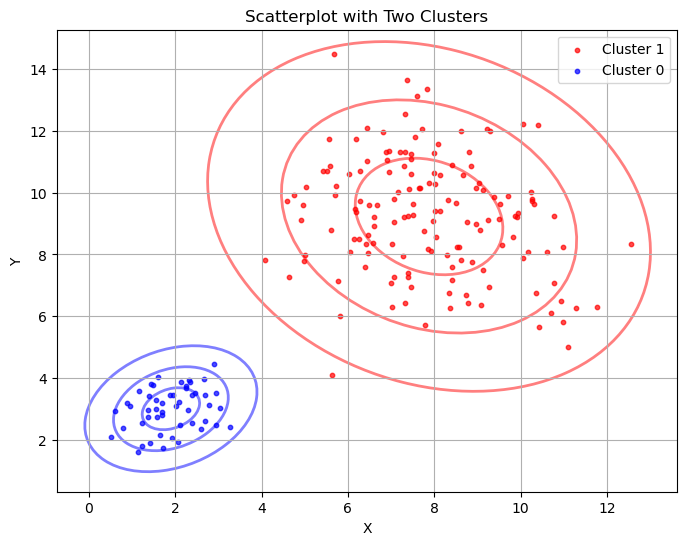

Iteration  10: Q=-811.0282302363136, pi=[0.75000311 0.24999689], mean=[[7.87911847 9.22850186]
 [1.9001563  3.00349293]]


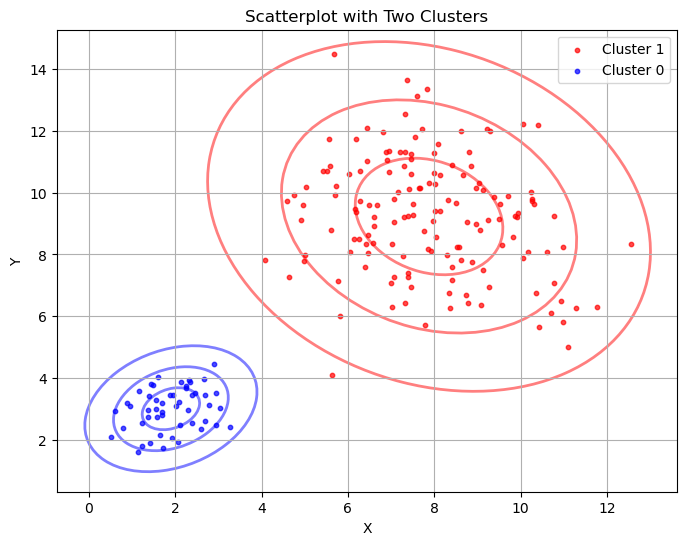

In [12]:
#initialization (you can play with initial parameters)
mean_it = [[1, 2], [0, 1]]
cov_it = [ [[1, 0], [0, 1]], [[1, 0], [0, 0.5]] ] 
pi_it = [0.2,0.8]

for it in range(10):
    Q, w = e_step(x_1, mean_it, cov_it, pi_it)
    pi_it,  mean_it, cov_it = m_step(x_1, w, mean_it, cov_it)
    print(f"Iteration {it+1:3d}: Q={Q}, pi={pi_it}, mean={mean_it}")
    scatter_cluster(x_1, w, mean_it, cov_it)

Run EM algorithm for sample 2

Iteration   1: Q=-790.5631420849833, pi=[0.07064858 0.92935142], mean=[[ 0.37240146 -0.10472414]
 [-0.02007878 -0.13912131]]


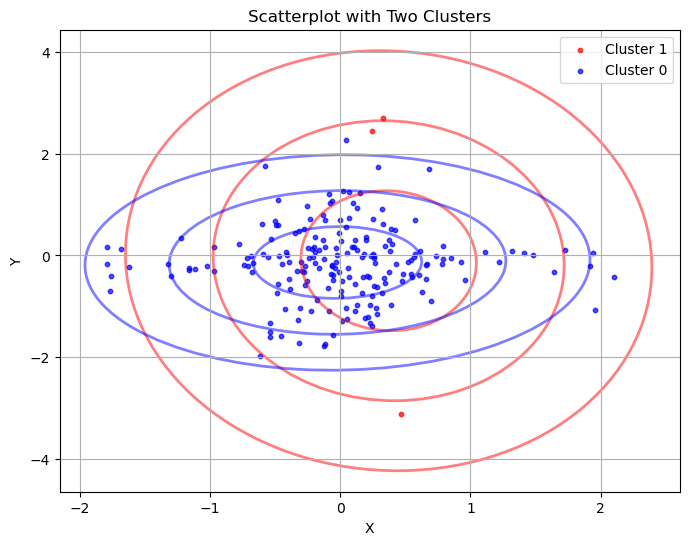

Iteration   2: Q=-467.29408132695784, pi=[0.07466447 0.92533553], mean=[[ 0.3309965   0.14218244]
 [-0.01844119 -0.15919326]]


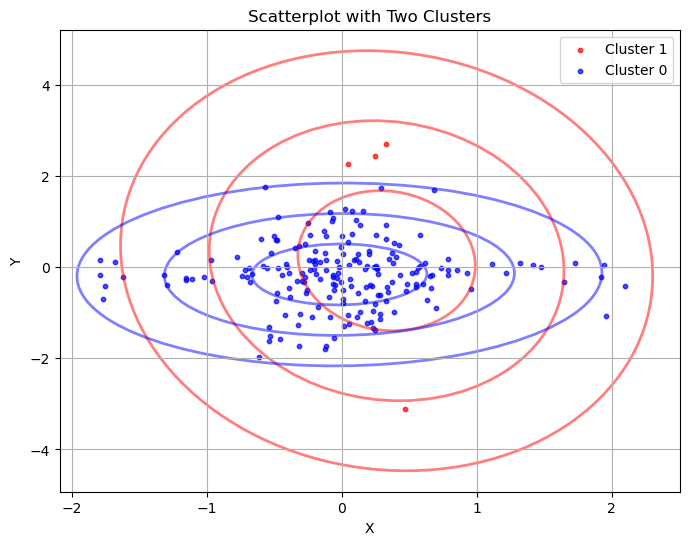

Iteration   3: Q=-464.2548390081587, pi=[0.07794957 0.92205043], mean=[[ 0.26674989  0.29398618]
 [-0.0142548  -0.1731004 ]]


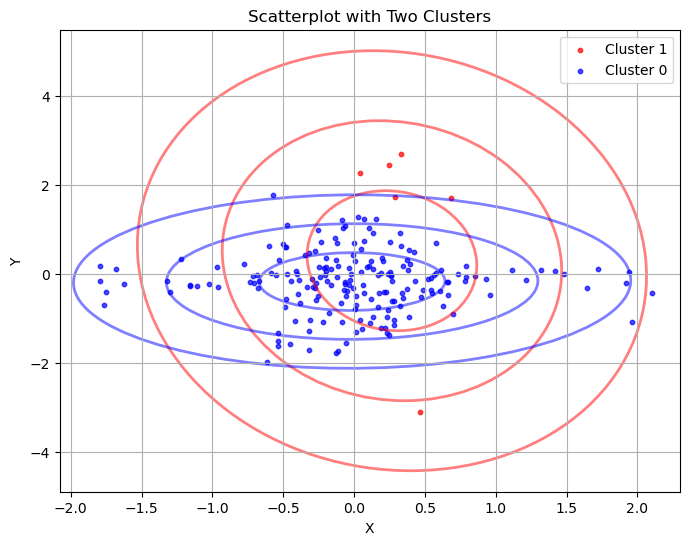

Iteration   4: Q=-463.62894979073695, pi=[0.0818618 0.9181382], mean=[[ 0.18424592  0.3614323 ]
 [-0.00809607 -0.18110421]]


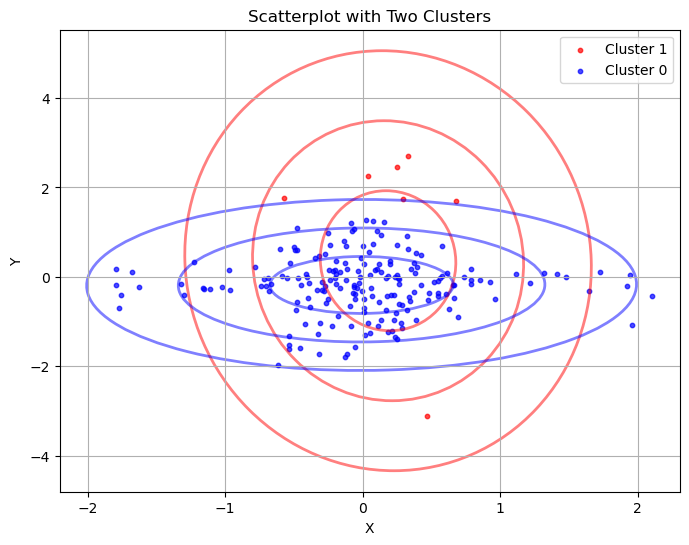

Iteration   5: Q=-463.8524065223726, pi=[0.09033176 0.90966824], mean=[[ 0.11420681  0.35920622]
 [-0.00293196 -0.18593474]]


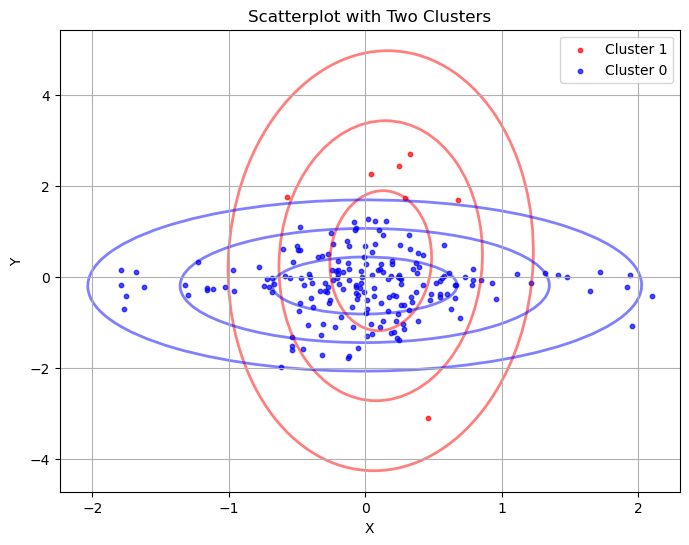

Iteration   6: Q=-466.2352430373313, pi=[0.10724388 0.89275612], mean=[[ 0.08381154  0.29658476]
 [-0.00149972 -0.18873923]]


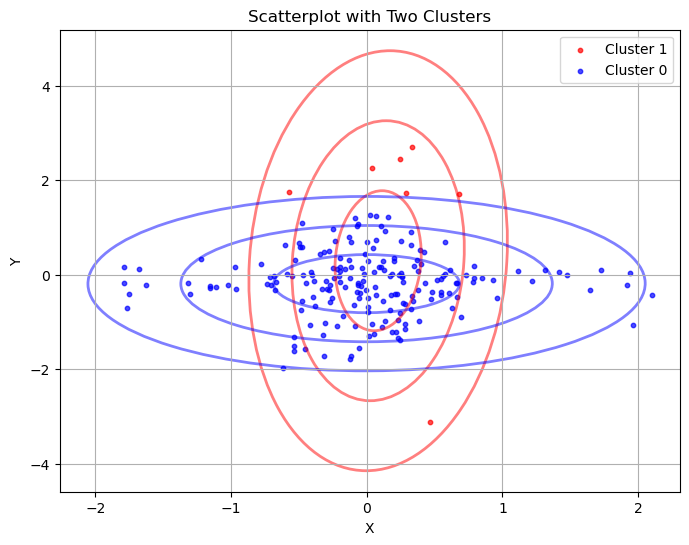

Iteration   7: Q=-470.90040624329174, pi=[0.12959785 0.87040215], mean=[[ 0.06691532  0.22193639]
 [-0.00117496 -0.19008877]]


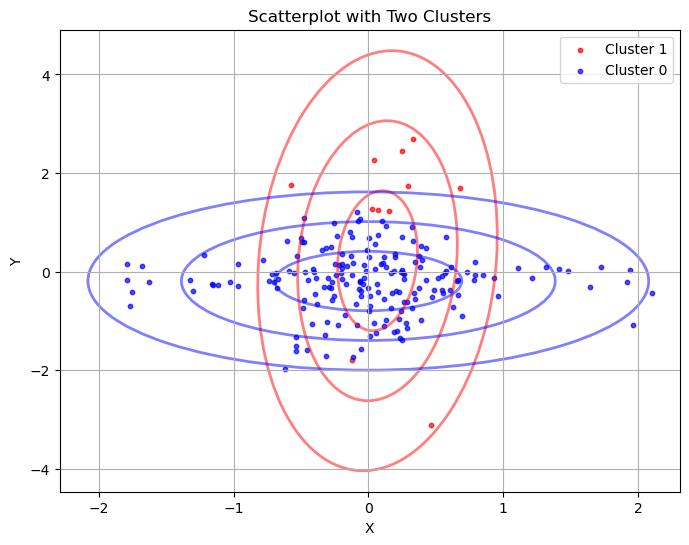

Iteration   8: Q=-476.12315338794286, pi=[0.1558907 0.8441093], mean=[[ 0.05204483  0.15257596]
 [-0.00054959 -0.19011326]]


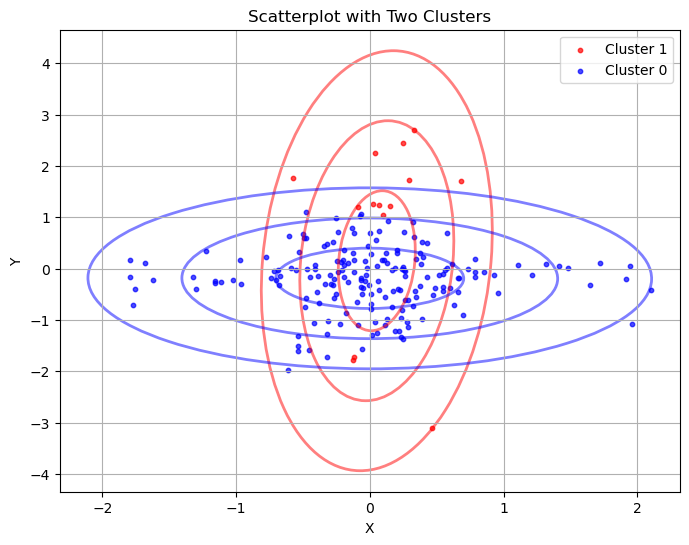

Iteration   9: Q=-480.97222480968543, pi=[0.1858922 0.8141078], mean=[[ 0.03640786  0.0901728 ]
 [ 0.00108273 -0.188493  ]]


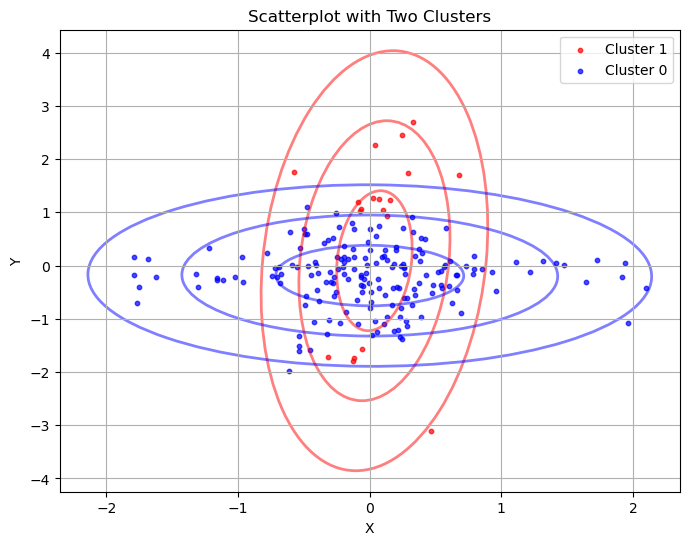

Iteration  10: Q=-484.7994081054817, pi=[0.21966442 0.78033558], mean=[[ 0.01986875  0.0339212 ]
 [ 0.00420964 -0.18471858]]


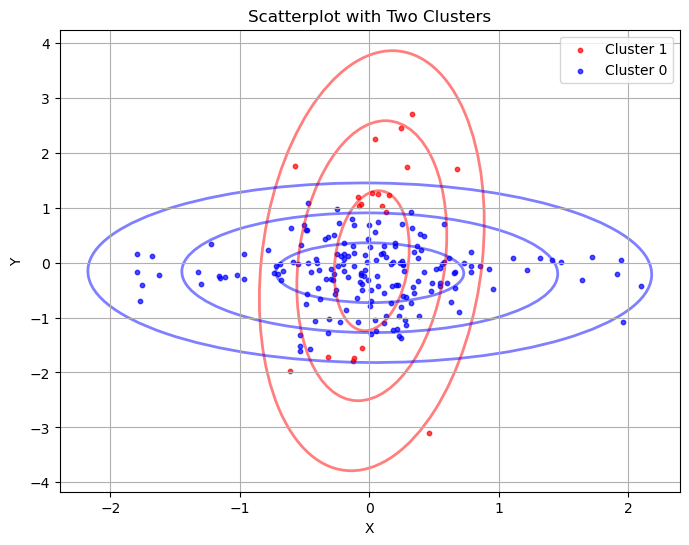

In [14]:
#initialization (you can play with initial parameters)
mean_it = [[1, 2], [0, 1]]
cov_it = [ [[1, 0], [0, 1]], [[1, 0], [0, 0.5]] ] 
pi_it = [0.2,0.8]

for it in range(10):
    Q, w = e_step(x_2, mean_it, cov_it, pi_it)
    pi_it,  mean_it, cov_it = m_step(x_2, w, mean_it, cov_it)
    print(f"Iteration {it+1:3d}: Q={Q}, pi={pi_it}, mean={mean_it}")
    scatter_cluster(x_2, w, mean_it, cov_it)